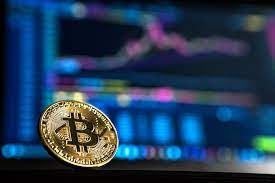

 <a id="1"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Importing Libraries</p>

In [ ]:
import pandas as pd 
import numpy as np
import random
import plotly.express as px
import plotly.offline as py
import gc
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,RocCurveDisplay,ConfusionMatrixDisplay,confusion_matrix,roc_auc_score,accuracy_score

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

 <a id="1"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Reading Data </p>

In [ ]:
train = pd.read_csv('../input/g-research-crypto-forecasting/train.csv') 
test = pd.read_csv('../input/g-research-crypto-forecasting/example_test.csv') 
sub = pd.read_csv('../input/g-research-crypto-forecasting/example_sample_submission.csv') 
asset_details = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')  

<a id="1"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Data Exploration</p>

In [ ]:
train.head(10)

In [ ]:
train.info()

In [ ]:
train.shape

In [ ]:
train.isna().sum()

In [ ]:
train['Target'] = train['Target'].fillna(0)

In [ ]:
train['VWAP'] = train['VWAP'].fillna(0)

In [ ]:
train.isna().sum()

In [ ]:
train.describe()

In [ ]:
#Finding correlation
plt.figure(figsize=(10,5))
ax=sns.heatmap(train.corr(),cmap="Set1",cbar=True,yticklabels=True,annot=True)
bottom,top=ax.get_ylim()
ax.set_ylim(bottom + 0.5,top -0.5)

In [ ]:
sns.barplot("High","Low",data=train.head(10),orient="v")

In [ ]:
for my_id in range(0,14):
    df_select =train[train.Asset_ID==my_id]
    plt.figure(figsize=(14,4))
    plt.scatter(df_select.timestamp, df_select.VWAP, s=1)
    my_title='Asset ID: ' + str(my_id) + ' - ' + asset_details[asset_details.Asset_ID==my_id].reset_index().Asset_Name[0]
    plt.title(my_title)
    plt.grid()
    plt.show()

In [ ]:
df_asset_details = asset_details.sort_values("Asset_ID")
df_asset_details

In [ ]:
sns.scatterplot(df_asset_details['Asset_ID'], df_asset_details['Weight'], hue = df_asset_details['Asset_Name'])

In [ ]:
px.scatter(df_asset_details, x="Weight", y="Asset_ID", color="Asset_Name")

In [ ]:
px.sunburst(df_asset_details, path=['Weight','Asset_Name'], values='Asset_ID')


In [ ]:
px.histogram(df_asset_details, x="Weight", y="Asset_ID", color="Asset_Name")

In [ ]:
import pandas as pd
import plotly.graph_objects as go
crypto_df = pd.read_csv("../input/g-research-crypto-forecasting/" + 'train.csv')
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp")
btc_mini = btc.iloc[-200:]
fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

In [ ]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. 
FOLDS = 5
# GAP FROM SPLIT TO SPLIT [SEE DETAILS ABOUT THE CV]
GROUP_GAP = 31

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2021 = 0
INC2020 = 1
INC2019 = 0
INC2018 = 0
INC2017 = 0
INCCOMP = 1
INCSUPP = 0

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [2048] * FOLDS
EPOCHS = [1] * FOLDS

# WHICH NETWORK ARCHITECTURE TO USE?
DEPTH_NETS = [2, 2, 2, 2, 2] 
WIDTH_NETS = [64, 64, 64, 64, 64]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1 / FOLDS] * FOLDS

In [ ]:
import os
import traceback
import gresearch_crypto
import tensorflow as tf
import pandas as pd, numpy as np
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [ ]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except: print("failed to initialize TPU")
    else: DEVICE = "GPU"

if DEVICE != "TPU": strategy = tf.distribute.get_strategy()
if DEVICE == "GPU": print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

In [ ]:
orig_df_train = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/train.csv')
supp_df_train = pd.read_csv('../input/g-research-crypto-forecasting/supplemental_train.csv')
df_asset_details = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/asset_details.csv').sort_values("Asset_ID")

extra_data_files = {
                        0: '../input/cryptocurrency-extra-data-binance-coin',
                        2: '../input/cryptocurrency-extra-data-bitcoin-cash',
                        1: '../input/cryptocurrency-extra-data-bitcoin',
                        3: '../input/cryptocurrency-extra-data-cardano',
                        4: '../input/cryptocurrency-extra-data-dogecoin',                        
                        5: '../input/cryptocurrency-extra-data-eos-io',
                        6: '../input/cryptocurrency-extra-data-ethereum',
                        7: '../input/cryptocurrency-extra-data-ethereum-classic', 
                        8: '../input/cryptocurrency-extra-data-iota',
                        9: '../input/cryptocurrency-extra-data-litecoin',
                        11: '../input/cryptocurrency-extra-data-monero',
                        10: '../input/cryptocurrency-extra-data-maker',
                        12: '../input/cryptocurrency-extra-data-stellar',
                        13: '../input/cryptocurrency-extra-data-tron'
                   }

def load_training_data_for_asset(asset_id):
    dfs = []        
    if INCCOMP: dfs.append(orig_df_train[orig_df_train["Asset_ID"] == asset_id].copy())
    if INCSUPP: dfs.append(supp_df_train[supp_df_train["Asset_ID"] == asset_id].copy())    
    if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'))
    if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'))
    if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'))
    if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'))
    if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'))
    df = pd.concat(dfs, axis = 0) if len(dfs) > 1 else dfs[0]
    df['date'] = pd.to_datetime(df['timestamp'], unit = 's')        
    df = df.sort_values('date')
    return df

In [ ]:
# Two features from the competition tutorial
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat["open_sub_close"] = df_feat["Open"] - df_feat["Close"]
    return df_feat

In [ ]:
def build_model(fold, dim = 128):
    inp = tf.keras.layers.Input(shape=(dim))
    x = inp
    
    for i in range(DEPTH_NETS[fold]):
        x = tf.keras.layers.Dense(WIDTH_NETS[fold])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs = inp, outputs = x)
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer=opt, loss='mse')
    return model

In [ ]:
def get_lr_callback(batch_size = 8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        else: lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [ ]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1

def get_Xy_and_model_for_asset(asset_id):
    df = load_training_data_for_asset(asset_id)
    df_proc = get_features(df)
    df_proc['date'] = df['date'].copy()
    df_proc['y'] = df['Target']
    df_proc = df_proc.dropna(how="any")
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]
    groups = pd.factorize(X['date'].dt.day.astype(str) + '_' + X['date'].dt.month.astype(str) + '_' + X['date'].dt.year.astype(str))[0]
    X = X.drop(columns = 'date')
    oof_preds = np.zeros(len(X))
    scores, models = [], []
    GROUP_GAP = 31
    
    for fold, (train_idx, val_idx) in enumerate(PurgedGroupTimeSeriesSplit(n_splits = FOLDS, group_gap = GROUP_GAP).split(X, y, groups)):
        # GET TRAINING, VALIDATION SET
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # DISPLAY FOLD INFO
        if DEVICE == 'TPU':
            if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
        print('#'*25); print('#### FOLD',fold+1)
        print('#### Training WIDTH %s DEPTH %s | batch_size %s' % (WIDTH_NETS[fold], DEPTH_NETS[fold], BATCH_SIZES[fold]*REPLICAS))

        # BUILD MODEL
        K.clear_session()
        with strategy.scope(): model = build_model(fold, dim = x_train.shape[1])

        # SAVE BEST MODEL EACH FOLD
        sv = tf.keras.callbacks.ModelCheckpoint('fold-%i.h5' % fold, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = True, mode = 'min', save_freq = 'epoch')

        # TRAIN
        print('Training...')
        history = model.fit( x_train, y_train, epochs = EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], validation_data = (x_val, y_val), verbose=VERBOSE )
        print('Loading best model...')
        model.load_weights('fold-%i.h5' % fold)

        # PREDICT OOF
        print('Predicting OOF...')
        pred = model.predict(x_val, verbose = VERBOSE)
        models.append(model)

        # REPORT RESULTS
        try: mse = mean_squared_error(np.nan_to_num(y_val), np.nan_to_num(pred))
        except: mse = 0.0
        scores.append(mse)
        oof_preds[val_idx] = pred[:,0]
        print('#### FOLD %i OOF MSE %.3f' % (fold + 1, mse))

    return scores, oof_preds, models

models = {}
scores = {}
oof_preds = {}
for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    cur_scores, cur_oof_preds, cur_models = get_Xy_and_model_for_asset(asset_id)
    scores[asset_id], oof_preds[asset_id], models[asset_id] = cur_scores, oof_preds, cur_models

In [ ]:
# COMPUTE OVERALL OOF MSE
print('Overall MEAN OOF MSE %s' % np.mean(list(scores.values())))

# SAVE OOF TO DISK 
for asset in oof_preds:
    df_oof = pd.DataFrame(dict(asset_id = asset, oof_preds=oof_preds))
    df_oof.to_csv(str(asset) + '_oof.csv',index=False)
    df_oof.head()

## Make A Sub.

In [ ]:
all_df_test = []

env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for i, (df_test, df_pred) in enumerate(iter_test):
    for j , row in df_test.iterrows():
        try:
            if row['Asset_ID'] in models:
                models = models[row['Asset_ID']]
                x_test = get_features(row)
                y_pred = np.mean(np.concatenate([np.expand_dims(model.predict(x_test)[0], axis = 0) for model in models], axis = 0), axis = 0)
            else: y_pred = 0.0
        except: 
            y_pred = 0.0
            traceback.print_exc()
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
    all_df_test.append(df_test)
    env.predict(df_pred)